# Código feito por Mateus Machado para análise da Intelivix

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from keras.layers import Dense, Dropout
from keras.models import Sequential
from pandas import DataFrame
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC

Using TensorFlow backend.


# Análise dos dados
Vamos dar uma olhada no nosso banco de dados, se ele está balanceado ou não, se ele é consistente ou não.

Transformei o .tsv em DataFrame do Pandas e vamos checar só as classes. 

In [2]:
df = pd.read_csv('./data/train.tsv', sep='\t', header=0)
feels = np.array(df['Sentimento'])
feelings = [0, 0, 0, 0, 0]
for f in feels:
    feelings[f] += 1

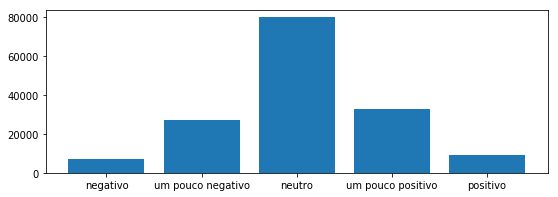

In [3]:
plt.figure(num=1, figsize=(9, 3))
plt.bar(['negativo', 'um pouco negativo', 'neutro',
         'um pouco positivo', 'positivo'], feelings)
plt.show()

Como podemos ver, o banco está longe de estar balanceado. Mas seria esse o jeito certo de se analisar? Se abrirmos o train.tsv, o banco é formado por várias sentenças e algumas frases derivadas. As frases derivadas também tem um "sentimento" associado. Então vou checar se, em relação as sentenças completas, se o banco está balanceado ou  não.

In [4]:
sentences = [0]
ids = []
last = len(sentences)
for i, idsent in enumerate(df.IdSentenca):
    if idsent > sentences[-1]:
        sentences.append(idsent)
        ids.append(i)

feelings = [0, 0, 0, 0, 0]
for i in ids:
    feelings[df.iloc[i]['Sentimento']] += 1

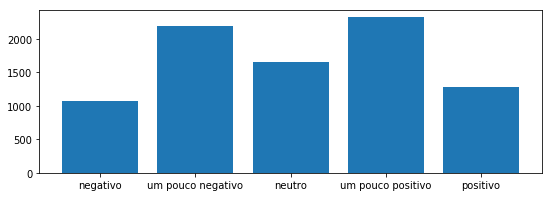

In [5]:
# Vamos ver a veradeira distribuição de classes em relação às sentenças
plt.figure(num=2, figsize=(9, 3))
plt.bar(['negativo', 'um pouco negativo', 'neutro',
         'um pouco positivo', 'positivo'], feelings)
plt.show()

Bem,  descobrimos que é um banco desbalanceado e além disso, inconsistente. Se formos ver o Id final da última sentença, ele dita 8544, porém só contamos 8530 sentenças. 

De primeira vista, iria balancear o banco, porém nunca trabalhei com classificação de texto. Vamos tentar sem balancear para ver o resultado e depois balanceando.



# Preprocessamento dos dados

Primeiramente, vamos "tokenizar" as sentenças, remover as "stopwords" e associar o vetor de tokens ao sentimento.
Para isso utilizei o CountVetorizer do Scikit. Depois vamos construir nossos vetores como features, usando frequência de termos e inverso de frequência de termos no documento (TF-IDF).

Após transformar as palavras do banco em features, podemos treinar nossos classificadores.


In [6]:
count_vect = CountVectorizer()
X_counts = count_vect.fit_transform(df.Texto)
tfidf_transformer = TfidfTransformer()
X_tfidf = tfidf_transformer.fit_transform(X_counts)
X_train = X_tfidf[:-1000]
X_test = X_tfidf[-1000:]
Y_train = df.Sentimento[:-1000]
Y_test = df.Sentimento[-1000:]

# Multinomial Naive Bayes
O primeiro algoritmo de classificação  que escolhi foi o Multinomial Naive Bayes, o qual é clássico para classificação de texto.



In [7]:
MNB = MultinomialNB()
MNB.fit(X_train,Y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [8]:
print("Acurácia Multinomial Naive Bayes",MNB.score(X_test, Y_test)*100)

Acurácia Multinomial Naive Bayes 59.5


# Linear Support Vector Classification

O segundo algoritmo que escolhi foi uma Support Vector Machine (SVM) de caráter linear. Funciona de forma parecida com o classificador de regressão linear fornecido pela Sciktit porém, supostamente, tem  melhor desempenho para grande quantidade de dados.


In [9]:
SVC = LinearSVC()
SVC.fit(X_train,Y_train)


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [10]:
print("Acurácia Linear Support Vector Classification",SVC.score(X_test, Y_test)*100)

Acurácia Linear Support Vector Classification 61.1


# Multilayer Perceptron
O terceiro e último algoritmo que escolhi foi o Multilayer Perceptron (MLP) com 3 camadas. Baseado na quantidade de dados, mais de 150.000, e sabendo que MLPs tem uma boa taxa de acertos em grande quantidade de dados, decidi fazer o teste. 

Treinei a MLP para 500 épocas para garantir a convergência, porém ela converge em menos tempo. Adotando um approach de early stop seria mais rápido.

In [11]:
MLP = Sequential()
MLP.add(Dense(units=32, activation='relu', input_dim=X_train.shape[1]))
MLP.add(Dropout(0.15))
MLP.add(Dense(units=64, activation='relu'))
MLP.add(Dropout(0.15))
MLP.add(Dense(units=128, activation='relu'))
MLP.add(Dropout(0.15))
MLP.add(Dense(units=5, activation='softmax'))
MLP.compile(loss='categorical_crossentropy', optimizer='sgd',metrics=['accuracy'])

In [12]:
Y = []
for label in df.Sentimento[:-1000]:
    l = [0 for _ in range(5)]
    l[label] = 1
    Y.append(l)
MLP.fit(X_train, np.array(Y), epochs=500, batch_size=128)

Epoch 1/500
155060/155060 [==============================] - 11s 71us/step - loss: 1.3119 - acc: 0.5095
Epoch 2/500
155060/155060 [==============================] - 10s 66us/step - loss: 1.2852 - acc: 0.5099
Epoch 3/500
155060/155060 [==============================] - 10s 67us/step - loss: 1.2841 - acc: 0.5099
Epoch 4/500
155060/155060 [==============================] - 10s 67us/step - loss: 1.2825 - acc: 0.5099
Epoch 5/500
155060/155060 [==============================] - 10s 68us/step - loss: 1.2804 - acc: 0.5099
Epoch 6/500
155060/155060 [==============================] - 10s 67us/step - loss: 1.2764 - acc: 0.5099
Epoch 7/500
155060/155060 [==============================] - 10s 67us/step - loss: 1.2695 - acc: 0.5099
Epoch 8/500
155060/155060 [==============================] - 10s 67us/step - loss: 1.2579 - acc: 0.5099
Epoch 9/500
155060/155060 [==============================] - 10s 67us/step - loss: 1.2427 - acc: 0.5108
Epoch 10/500
155060/155060 [==============================] - 10

155060/155060 [==============================] - 9s 61us/step - loss: 0.5922 - acc: 0.7521
Epoch 80/500
155060/155060 [==============================] - 9s 61us/step - loss: 0.5874 - acc: 0.7542
Epoch 81/500
155060/155060 [==============================] - 9s 60us/step - loss: 0.5849 - acc: 0.7539
Epoch 82/500
155060/155060 [==============================] - 9s 60us/step - loss: 0.5840 - acc: 0.7562
Epoch 83/500
155060/155060 [==============================] - 9s 60us/step - loss: 0.5775 - acc: 0.7588
Epoch 84/500
155060/155060 [==============================] - 9s 60us/step - loss: 0.5794 - acc: 0.7589
Epoch 85/500
155060/155060 [==============================] - 9s 60us/step - loss: 0.5759 - acc: 0.7577
Epoch 86/500
155060/155060 [==============================] - 9s 60us/step - loss: 0.5741 - acc: 0.7598
Epoch 87/500
155060/155060 [==============================] - 9s 60us/step - loss: 0.5719 - acc: 0.7600
Epoch 88/500
155060/155060 [==============================] - 9s 60us/step - 

155060/155060 [==============================] - 9s 60us/step - loss: 0.4550 - acc: 0.8101
Epoch 158/500
155060/155060 [==============================] - 9s 61us/step - loss: 0.4543 - acc: 0.8099
Epoch 159/500
155060/155060 [==============================] - 9s 61us/step - loss: 0.4510 - acc: 0.8109
Epoch 160/500
155060/155060 [==============================] - 9s 60us/step - loss: 0.4515 - acc: 0.8116
Epoch 161/500
155060/155060 [==============================] - 9s 60us/step - loss: 0.4493 - acc: 0.8123
Epoch 162/500
155060/155060 [==============================] - 9s 60us/step - loss: 0.4468 - acc: 0.8136
Epoch 163/500
155060/155060 [==============================] - 9s 60us/step - loss: 0.4465 - acc: 0.8127
Epoch 164/500
155060/155060 [==============================] - 9s 60us/step - loss: 0.4489 - acc: 0.8123
Epoch 165/500
155060/155060 [==============================] - 9s 60us/step - loss: 0.4472 - acc: 0.8144
Epoch 166/500
155060/155060 [==============================] - 9s 60u

155060/155060 [==============================] - 9s 61us/step - loss: 0.3913 - acc: 0.8366
Epoch 235/500
155060/155060 [==============================] - 9s 60us/step - loss: 0.3876 - acc: 0.8384
Epoch 236/500
155060/155060 [==============================] - 9s 60us/step - loss: 0.3869 - acc: 0.8385
Epoch 237/500
155060/155060 [==============================] - 9s 60us/step - loss: 0.3861 - acc: 0.8394
Epoch 238/500
155060/155060 [==============================] - 9s 60us/step - loss: 0.3881 - acc: 0.8390
Epoch 239/500
155060/155060 [==============================] - 9s 60us/step - loss: 0.3879 - acc: 0.8379
Epoch 240/500
155060/155060 [==============================] - 9s 60us/step - loss: 0.3858 - acc: 0.8395
Epoch 241/500
155060/155060 [==============================] - 9s 60us/step - loss: 0.3874 - acc: 0.8392
Epoch 242/500
155060/155060 [==============================] - 9s 60us/step - loss: 0.3838 - acc: 0.8404
Epoch 243/500
155060/155060 [==============================] - 9s 60u

155060/155060 [==============================] - 9s 61us/step - loss: 0.3505 - acc: 0.8534
Epoch 312/500
155060/155060 [==============================] - 9s 60us/step - loss: 0.3509 - acc: 0.8538
Epoch 313/500
155060/155060 [==============================] - 9s 60us/step - loss: 0.3506 - acc: 0.8536
Epoch 314/500
155060/155060 [==============================] - 9s 60us/step - loss: 0.3511 - acc: 0.8533
Epoch 315/500
155060/155060 [==============================] - 9s 60us/step - loss: 0.3485 - acc: 0.8538
Epoch 316/500
155060/155060 [==============================] - 9s 60us/step - loss: 0.3486 - acc: 0.8544
Epoch 317/500
155060/155060 [==============================] - 9s 60us/step - loss: 0.3487 - acc: 0.8545
Epoch 318/500
155060/155060 [==============================] - 9s 60us/step - loss: 0.3489 - acc: 0.8545
Epoch 319/500
155060/155060 [==============================] - 9s 60us/step - loss: 0.3483 - acc: 0.8546
Epoch 320/500
155060/155060 [==============================] - 9s 60u

155060/155060 [==============================] - 9s 61us/step - loss: 0.3245 - acc: 0.8641
Epoch 389/500
155060/155060 [==============================] - 9s 60us/step - loss: 0.3264 - acc: 0.8624
Epoch 390/500
155060/155060 [==============================] - 11s 73us/step - loss: 0.3257 - acc: 0.8640
Epoch 391/500
155060/155060 [==============================] - 11s 71us/step - loss: 0.3249 - acc: 0.8637
Epoch 392/500
155060/155060 [==============================] - 11s 69us/step - loss: 0.3252 - acc: 0.8638
Epoch 393/500
155060/155060 [==============================] - 11s 72us/step - loss: 0.3254 - acc: 0.8633
Epoch 394/500
155060/155060 [==============================] - 11s 71us/step - loss: 0.3235 - acc: 0.8651
Epoch 395/500
155060/155060 [==============================] - 11s 70us/step - loss: 0.3259 - acc: 0.8630
Epoch 396/500
155060/155060 [==============================] - 9s 61us/step - loss: 0.3236 - acc: 0.8644
Epoch 397/500
155060/155060 [==============================] - 

155060/155060 [==============================] - 9s 61us/step - loss: 0.3064 - acc: 0.8698
Epoch 466/500
155060/155060 [==============================] - 9s 61us/step - loss: 0.3082 - acc: 0.8704
Epoch 467/500
155060/155060 [==============================] - 9s 61us/step - loss: 0.3075 - acc: 0.8700
Epoch 468/500
155060/155060 [==============================] - 9s 61us/step - loss: 0.3079 - acc: 0.8697
Epoch 469/500
155060/155060 [==============================] - 9s 60us/step - loss: 0.3082 - acc: 0.8694
Epoch 470/500
155060/155060 [==============================] - 9s 60us/step - loss: 0.3078 - acc: 0.8697
Epoch 471/500
155060/155060 [==============================] - 9s 61us/step - loss: 0.3066 - acc: 0.8709
Epoch 472/500
155060/155060 [==============================] - 9s 60us/step - loss: 0.3081 - acc: 0.8700
Epoch 473/500
155060/155060 [==============================] - 9s 60us/step - loss: 0.3084 - acc: 0.8708
Epoch 474/500
155060/155060 [==============================] - 9s 60u

In [13]:
y_test = []
for label in Y_test:
    l = [0 for _ in range(5)]
    l[label] = 1
    y_test.append(l)
loss_and_metrics = MLP.evaluate(X_test, np.array(y_test), batch_size=128)
print("Acurácia Multilayer Perceptron",loss_and_metrics[1]*100)

1000/1000 [==============================] - 0s 139us/step
Acurácia Multilayer Perceptron 58.29999980926514


# Balanceando os dados

Tivemos resultados razoáveis com os dados desbalanceados, agora vamos fazer um experimento balanceando os dados. 

Farei um "undersample" aleatório das classes majoritárias.


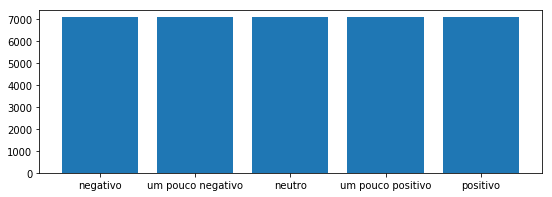

In [14]:
# Separo por classes
feels = np.array(df['Sentimento'])
feelings = [0, 0, 0, 0, 0]
for f in feels:
    feelings[f] += 1

df_class_0 = df[df['Sentimento'] == 0]
df_class_1 = df[df['Sentimento'] == 1]
df_class_2 = df[df['Sentimento'] == 2]
df_class_3 = df[df['Sentimento'] == 3]
df_class_4 = df[df['Sentimento'] == 4]

# Faço o undersample das classes majoritárias
df_class_1 = df_class_1.sample(feelings[0])
df_class_2 = df_class_2.sample(feelings[0])
df_class_3 = df_class_3.sample(feelings[0])
df_class_4 = df_class_4.sample(feelings[0])

# Crio um novo DataFrame para classes balanceadas
balanced = pd.concat([df_class_0, df_class_1, df_class_2, df_class_3, df_class_4], axis=0)
balanced = balanced.sample(frac=1).reset_index(drop=True)
feels = np.array(balanced['Sentimento'])
feelings = [0, 0, 0, 0, 0]
for f in feels:
    feelings[f] += 1
plt.figure(num=3, figsize=(9, 3))
plt.bar(['negativo', 'um pouco negativo', 'neutro',
         'um pouco positivo', 'positivo'], feelings)
plt.show()

A partir daqui, irei apenas repetir o experimento anterior com os três classificadores.

In [15]:
X_counts = count_vect.fit_transform(balanced.Texto)
tfidf_transformer = TfidfTransformer()
X_tfidf = tfidf_transformer.fit_transform(X_counts)
X_train = X_tfidf[:-1000]
X_test = X_tfidf[-1000:]
Y_train = balanced.Sentimento[:-1000]
Y_test = balanced.Sentimento[-1000:]

In [16]:
MNB = MultinomialNB()
MNB.fit(X_train,Y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [17]:
print("Acurácia Multinomial Naive Bayes",MNB.score(X_test, Y_test)*100)

Acurácia Multinomial Naive Bayes 47.8


In [18]:
SVC = LinearSVC()
SVC.fit(X_train,Y_train)


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [19]:
print("Acurácia Linear Support Vector Classification",SVC.score(X_test, Y_test)*100)

Acurácia Linear Support Vector Classification 55.2


In [20]:
MLP = Sequential()
MLP.add(Dense(units=32, activation='relu', input_dim=X_train.shape[1]))
MLP.add(Dropout(0.15))
MLP.add(Dense(units=64, activation='relu'))
MLP.add(Dropout(0.15))
MLP.add(Dense(units=128, activation='relu'))
MLP.add(Dropout(0.15))
MLP.add(Dense(units=5, activation='softmax'))
MLP.compile(loss='categorical_crossentropy', optimizer='sgd',metrics=['accuracy'])

In [21]:
Y = []
for label in balanced.Sentimento[:-1000]:
    l = [0 for _ in range(5)]
    l[label] = 1
    Y.append(l)
MLP.fit(X_train, np.array(Y), epochs=500, batch_size=128)

Epoch 1/500
34360/34360 [==============================] - 3s 77us/step - loss: 1.6095 - acc: 0.1990
Epoch 2/500
34360/34360 [==============================] - 2s 65us/step - loss: 1.6094 - acc: 0.2047
Epoch 3/500
34360/34360 [==============================] - 2s 66us/step - loss: 1.6093 - acc: 0.2122
Epoch 4/500
34360/34360 [==============================] - 2s 65us/step - loss: 1.6092 - acc: 0.2124
Epoch 5/500
34360/34360 [==============================] - 2s 65us/step - loss: 1.6090 - acc: 0.2212
Epoch 6/500
34360/34360 [==============================] - 2s 66us/step - loss: 1.6089 - acc: 0.2208
Epoch 7/500
34360/34360 [==============================] - 2s 66us/step - loss: 1.6087 - acc: 0.2212
Epoch 8/500
34360/34360 [==============================] - 2s 65us/step - loss: 1.6085 - acc: 0.2310
Epoch 9/500
34360/34360 [==============================] - 2s 65us/step - loss: 1.6081 - acc: 0.2398
Epoch 10/500
34360/34360 [==============================] - 2s 65us/step - loss: 1.6079 - a

34360/34360 [==============================] - 2s 66us/step - loss: 0.9118 - acc: 0.6077
Epoch 81/500
34360/34360 [==============================] - 2s 66us/step - loss: 0.9004 - acc: 0.6109
Epoch 82/500
34360/34360 [==============================] - 2s 66us/step - loss: 0.9018 - acc: 0.6111
Epoch 83/500
34360/34360 [==============================] - 2s 65us/step - loss: 0.9040 - acc: 0.6109
Epoch 84/500
34360/34360 [==============================] - 2s 66us/step - loss: 0.8961 - acc: 0.6115
Epoch 85/500
34360/34360 [==============================] - 2s 65us/step - loss: 0.8758 - acc: 0.6263
Epoch 86/500
34360/34360 [==============================] - 2s 65us/step - loss: 0.8729 - acc: 0.6248
Epoch 87/500
34360/34360 [==============================] - 2s 65us/step - loss: 0.8730 - acc: 0.6237
Epoch 88/500
34360/34360 [==============================] - 2s 65us/step - loss: 0.8605 - acc: 0.6301
Epoch 89/500
34360/34360 [==============================] - 2s 66us/step - loss: 0.8634 - acc: 

34360/34360 [==============================] - 2s 66us/step - loss: 0.5756 - acc: 0.7662
Epoch 160/500
34360/34360 [==============================] - 2s 65us/step - loss: 0.5599 - acc: 0.7705
Epoch 161/500
34360/34360 [==============================] - 2s 66us/step - loss: 0.5465 - acc: 0.7777
Epoch 162/500
34360/34360 [==============================] - 2s 65us/step - loss: 0.5603 - acc: 0.7739
Epoch 163/500
34360/34360 [==============================] - 2s 65us/step - loss: 0.5605 - acc: 0.7728
Epoch 164/500
34360/34360 [==============================] - 2s 65us/step - loss: 0.5552 - acc: 0.7756
Epoch 165/500
34360/34360 [==============================] - 2s 65us/step - loss: 0.5953 - acc: 0.7579
Epoch 166/500
34360/34360 [==============================] - 2s 66us/step - loss: 0.6219 - acc: 0.7451
Epoch 167/500
34360/34360 [==============================] - 2s 65us/step - loss: 0.5666 - acc: 0.7680
Epoch 168/500
34360/34360 [==============================] - 2s 65us/step - loss: 0.522

34360/34360 [==============================] - 2s 66us/step - loss: 0.3843 - acc: 0.8492
Epoch 239/500
34360/34360 [==============================] - 2s 66us/step - loss: 0.4628 - acc: 0.8244
Epoch 240/500
34360/34360 [==============================] - 2s 66us/step - loss: 0.4794 - acc: 0.8109
Epoch 241/500
34360/34360 [==============================] - 2s 65us/step - loss: 0.5401 - acc: 0.7869
Epoch 242/500
34360/34360 [==============================] - 2s 65us/step - loss: 0.4427 - acc: 0.8237
Epoch 243/500
34360/34360 [==============================] - 2s 65us/step - loss: 0.4735 - acc: 0.8199
Epoch 244/500
34360/34360 [==============================] - 2s 65us/step - loss: 0.4021 - acc: 0.8416
Epoch 245/500
34360/34360 [==============================] - 2s 65us/step - loss: 0.3875 - acc: 0.8500
Epoch 246/500
34360/34360 [==============================] - 2s 65us/step - loss: 0.3963 - acc: 0.8446
Epoch 247/500
34360/34360 [==============================] - 2s 66us/step - loss: 0.393

34360/34360 [==============================] - 2s 66us/step - loss: 0.3124 - acc: 0.8802
Epoch 318/500
34360/34360 [==============================] - 2s 66us/step - loss: 0.2918 - acc: 0.8865
Epoch 319/500
34360/34360 [==============================] - 2s 65us/step - loss: 0.2895 - acc: 0.8880
Epoch 320/500
34360/34360 [==============================] - 2s 65us/step - loss: 0.2986 - acc: 0.8861
Epoch 321/500
34360/34360 [==============================] - 2s 65us/step - loss: 0.2845 - acc: 0.8898
Epoch 322/500
34360/34360 [==============================] - 2s 65us/step - loss: 0.2746 - acc: 0.8941
Epoch 323/500
34360/34360 [==============================] - 2s 65us/step - loss: 0.2890 - acc: 0.8867
Epoch 324/500
34360/34360 [==============================] - 2s 65us/step - loss: 0.3042 - acc: 0.8841
Epoch 325/500
34360/34360 [==============================] - 2s 65us/step - loss: 0.2784 - acc: 0.8944
Epoch 326/500
34360/34360 [==============================] - 2s 65us/step - loss: 0.272

34360/34360 [==============================] - 2s 66us/step - loss: 0.2138 - acc: 0.9161
Epoch 397/500
34360/34360 [==============================] - 2s 65us/step - loss: 0.2143 - acc: 0.9156
Epoch 398/500
34360/34360 [==============================] - 2s 66us/step - loss: 0.2310 - acc: 0.9119
Epoch 399/500
34360/34360 [==============================] - 2s 65us/step - loss: 0.2139 - acc: 0.9160
Epoch 400/500
34360/34360 [==============================] - 2s 65us/step - loss: 0.2188 - acc: 0.9135
Epoch 401/500
34360/34360 [==============================] - 2s 65us/step - loss: 0.2090 - acc: 0.9182
Epoch 402/500
34360/34360 [==============================] - 2s 65us/step - loss: 0.2148 - acc: 0.9170
Epoch 403/500
34360/34360 [==============================] - 2s 65us/step - loss: 0.2111 - acc: 0.9180
Epoch 404/500
34360/34360 [==============================] - 2s 65us/step - loss: 0.2155 - acc: 0.9162
Epoch 405/500
34360/34360 [==============================] - 2s 65us/step - loss: 0.215

34360/34360 [==============================] - 2s 66us/step - loss: 0.1899 - acc: 0.9242
Epoch 476/500
34360/34360 [==============================] - 2s 65us/step - loss: 0.1949 - acc: 0.9235
Epoch 477/500
34360/34360 [==============================] - 2s 66us/step - loss: 0.1830 - acc: 0.9278
Epoch 478/500
34360/34360 [==============================] - 2s 66us/step - loss: 0.1859 - acc: 0.9252
Epoch 479/500
34360/34360 [==============================] - 2s 65us/step - loss: 0.1864 - acc: 0.9253
Epoch 480/500
34360/34360 [==============================] - 2s 65us/step - loss: 0.2273 - acc: 0.9102
Epoch 481/500
34360/34360 [==============================] - 2s 65us/step - loss: 0.1894 - acc: 0.9262
Epoch 482/500
34360/34360 [==============================] - 2s 65us/step - loss: 0.1872 - acc: 0.9259
Epoch 483/500
34360/34360 [==============================] - 2s 65us/step - loss: 0.1907 - acc: 0.9244
Epoch 484/500
34360/34360 [==============================] - 2s 64us/step - loss: 0.184

In [22]:
y_test = []
for label in Y_test:
    l = [0 for _ in range(5)]
    l[label] = 1
    y_test.append(l)
loss_and_metrics = MLP.evaluate(X_test, np.array(y_test), batch_size=128)
print("Acurácia Multilayer Perceptron",loss_and_metrics[1]*100)

1000/1000 [==============================] - 0s 147us/step
Acurácia Multilayer Perceptron 57.60000023841858


# Conclusão

Obtivemos resultados interessantes.
Como esperado, com o Naive Bayes com o balanceamento tivemos uma acurácia menor, pois quanto mais dados, melhor para o algoritmo, independendo do balanceamento dos dados.

Os algoritmos de LinearSVC e MLP me surpreenderam após o balanceamento dos dados. Talvez pela imensa perda de dados que tivemos quando fiz o undersample, eles tiveram uma perfomance menor do que com os dados desbalanceados. Talvez com um oversample ou um tipo de geração de protótipos (ex. LVQ3), poderíamos ter um resultado mais eficiente.

O algoritmo que se sobressiu foi o de LinearSVC com 61% de acurácia.

# O que gostaria ter incluído no projeto

Como me interesso muito pela área de Deep Learning, gostaria de ter aplicado alguma das técnicas citadas em "Deep Learning for Sentiment Analysis : A Survey", Lei Zhang, Shuai Wang, Bing Liu. Infelizmente, por ser novo na área de análise de texto, não tive o tempo suficiente para pesquisar sobre como aplicar no contexto dado.

Um detalhe que queria ter feito é não ter usado o pré processamento do Scikit e ter desenvolvido um próprio. Ainda comecei a desenvolver um mas não daria tempo de criar um bom vetor de palavras utilizando uma lookup table de matrizes esparças, como faz o scikit.

Algo que me deixou curioso e não consegui aplicar foi o Word2Vec/Sen2Vec/Doc2Vec. Pesquisei por cima como eram treinados os modelos mas não achei nenhum que retornasse o modelo como um numpy array. 

## Agradeço a oportunidade
Abraços!